# This is an introductory Tensorflow and Tensorflow-graphics Jupyter *notebook*


## Copyright 2022 Dr. George Papagiannakis, papagian@csd.uoc.gr
### All Rights Reserved

### University of Crete & Foundation for Research & Technology - Hellas (FORTH)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import sys
%matplotlib inline

# Installation instructions of tensorflow 2
### make sure you install tensorflow via pip and not conda! 
- for windows and macOS Intel: https://365datascience.com/tutorials/machine-learning-tutorials/install-tensorflow-2-anaconda/ 
- for M1 macOS: https://caffeinedev.medium.com/how-to-install-tensorflow-on-m1-mac-8e9b91d93706 

In [3]:
import tensorflow as tf
import keras
import tensorflow_datasets as tfds
import platform

print(f"Python Platform: {platform.platform()}")
print("TensorFlow version:", tf.__version__)
print(f"Keras version: {keras.__version__}")
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-Learn version: {sk.__version__}")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Python Platform: macOS-10.16-x86_64-i386-64bit
TensorFlow version: 2.10.0
Keras version: 2.10.0
Python version: 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
Pandas version: 1.3.5
Scikit-Learn version: 1.0.2
Num GPUs Available:  1


## install tensorflow-graphics

You can try with pip, but if you have problems then you can follow the workarounds below:
- get from github the source of tensorflow-graphics
- comment from requirements.txt OpenEXR
- install OpenEXR via macports or Homebrew
- manually install tensorflow-graphics from the github source:
  - `python setup.py sdist bdist_wheel`
  - `pip install --upgrade dist/*.whl`

In [4]:
# check here tensorflow-graphics

###########
# Imports #
###########
import math

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow_graphics.geometry.representation import grid
from tensorflow_graphics.geometry.representation import ray
from tensorflow_graphics.geometry.representation import vector
from tensorflow_graphics.rendering.camera import orthographic
from tensorflow_graphics.math import spherical_harmonics
from tensorflow_graphics.math import math_helpers as tf_math

tf.compat.v1.enable_eager_execution()


## Approximation of lighting with Spherical Harmonics

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 7.15 µs
average l2 reconstruction error  0.0028318241022768425
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.39 µs


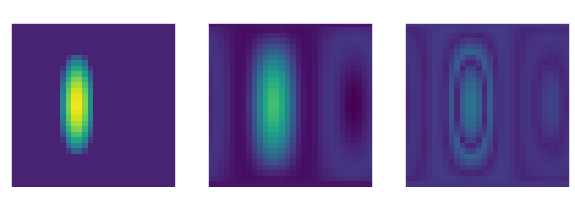

In [9]:
%time
#@title Controls { vertical-output: false, run: "auto" }
max_band = 3  #@param { type: "slider", min: 0, max: 10 , step: 1 }

#########################################################################
# This cell creates a lighting function which we approximate with an SH #
#########################################################################

def image_to_spherical_coordinates(image_width, image_height):
  pixel_grid_start = np.array((0, 0), dtype=type)
  pixel_grid_end = np.array((image_width - 1, image_height - 1), dtype=type)
  pixel_nb = np.array((image_width, image_height))
  pixels = grid.generate(pixel_grid_start, pixel_grid_end, pixel_nb)
  normalized_pixels = pixels / (image_width - 1, image_height - 1)
  spherical_coordinates = tf_math.square_to_spherical_coordinates(
      normalized_pixels)
  return spherical_coordinates


def light_function(theta, phi):
  theta = tf.convert_to_tensor(theta)
  phi = tf.convert_to_tensor(phi)
  zero = tf.zeros_like(theta)
  return tf.maximum(zero,
                    -4.0 * tf.sin(theta - np.pi) * tf.cos(phi - 2.5) - 3.0)


light_image_width = 30
light_image_height = 30
type = np.float64

# Builds the pixels grid and compute corresponding spherical coordinates.
spherical_coordinates = image_to_spherical_coordinates(light_image_width,
                                                       light_image_height)
theta = spherical_coordinates[:, :, 1]
phi = spherical_coordinates[:, :, 2]

# Samples the light function.
sampled_light_function = light_function(theta, phi)
ones_normal = tf.ones_like(theta)
spherical_coordinates_3d = tf.stack((ones_normal, theta, phi), axis=-1)
samples_direction_to_light = tf_math.spherical_to_cartesian_coordinates(
    spherical_coordinates_3d)

# Samples the SH.
l, m = spherical_harmonics.generate_l_m_permutations(max_band)
l = tf.convert_to_tensor(l)
m = tf.convert_to_tensor(m)
l_broadcasted = tf.broadcast_to(l, [light_image_width, light_image_height] +
                                l.shape.as_list())
m_broadcasted = tf.broadcast_to(m, [light_image_width, light_image_height] +
                                l.shape.as_list())
theta = tf.expand_dims(theta, axis=-1)
theta_broadcasted = tf.broadcast_to(
    theta, [light_image_width, light_image_height, 1])
phi = tf.expand_dims(phi, axis=-1)
phi_broadcasted = tf.broadcast_to(phi, [light_image_width, light_image_height, 1])
sh_coefficients = spherical_harmonics.evaluate_spherical_harmonics(
    l_broadcasted, m_broadcasted, theta_broadcasted, phi_broadcasted)
sampled_light_function_broadcasted = tf.expand_dims(
    sampled_light_function, axis=-1)
sampled_light_function_broadcasted = tf.broadcast_to(
    sampled_light_function_broadcasted,
    [light_image_width, light_image_height] + l.shape.as_list())

# Integrates the light function times SH over the sphere.
projection = sh_coefficients * sampled_light_function_broadcasted * 4.0 * math.pi / (
    light_image_width * light_image_height)
light_coeffs = tf.reduce_sum(projection, (0, 1))

# Reconstructs the image.
reconstructed_light_function = tf.squeeze(
    vector.dot(sh_coefficients, light_coeffs))

print(
    "average l2 reconstruction error ",
    np.linalg.norm(sampled_light_function - reconstructed_light_function) /
    (light_image_width * light_image_height))

vmin = np.minimum(
    np.amin(np.minimum(sampled_light_function, reconstructed_light_function)),
    0.0)
vmax = np.maximum(
    np.amax(np.maximum(sampled_light_function, reconstructed_light_function)),
    1.0)
# Plots results.
plt.figure(figsize=(10, 10))
ax = plt.subplot(131)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.grid(False)
ax.set_title("Original lighting function")
_ = ax.imshow(sampled_light_function, vmin=vmin, vmax=vmax)
ax = plt.subplot(132)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.grid(False)
ax.set_title("Spherical Harmonics approximation")
_ = ax.imshow(reconstructed_light_function, vmin=vmin, vmax=vmax)
ax = plt.subplot(133)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.grid(False)
ax.set_title("Difference")
_ = ax.imshow(
    np.abs(reconstructed_light_function - sampled_light_function),
    vmin=vmin,
    vmax=vmax)

%time